In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import gymnasium as gym
from mountain.envs.mountain import MountainEnv

In [2]:
# Load trajectories from pickle file
with open("trajectories.pickle", "rb") as f:
    trajectories = pickle.load(f)

In [3]:
def set_seed(seed=42):
    """
    Sets the random seed for NumPy, Python, and Gym for reproducibility.
    """
    np.random.seed(seed)
    random.seed(seed)

In [4]:
# Monte Carlo evaluation for vπ(s)
def mc_value_function(trajectories, gamma=0.9):
    returns = defaultdict(list)
    V = {}

    for episode in trajectories:
        G = 0
        visited_states = set()
        for t in reversed(range(len(episode))):
            state, action, reward, next_state = episode[t]
            G = gamma * G + reward
            if state not in visited_states:
                returns[state].append(G)
                visited_states.add(state)

    for state in returns:
        V[state] = np.mean(returns[state])

    return V

In [5]:
# Monte Carlo evaluation for qπ(a, s)
def mc_action_value_function(trajectories, gamma=0.9):
    returns = defaultdict(lambda: defaultdict(list))
    Q = defaultdict(lambda: defaultdict(float))

    for episode in trajectories:
        G = 0
        visited_state_actions = set()
        for t in reversed(range(len(episode))):
            state, action, reward, next_state = episode[t]
            G = gamma * G + reward
            if (state, action) not in visited_state_actions:
                returns[state][action].append(G)
                visited_state_actions.add((state, action))

    for state in returns:
        for action in returns[state]:
            Q[state][action] = np.mean(returns[state][action])

    return Q

In [6]:
# Compute the value functions
V_pi = mc_value_function(trajectories)
Q_pi = mc_action_value_function(trajectories)

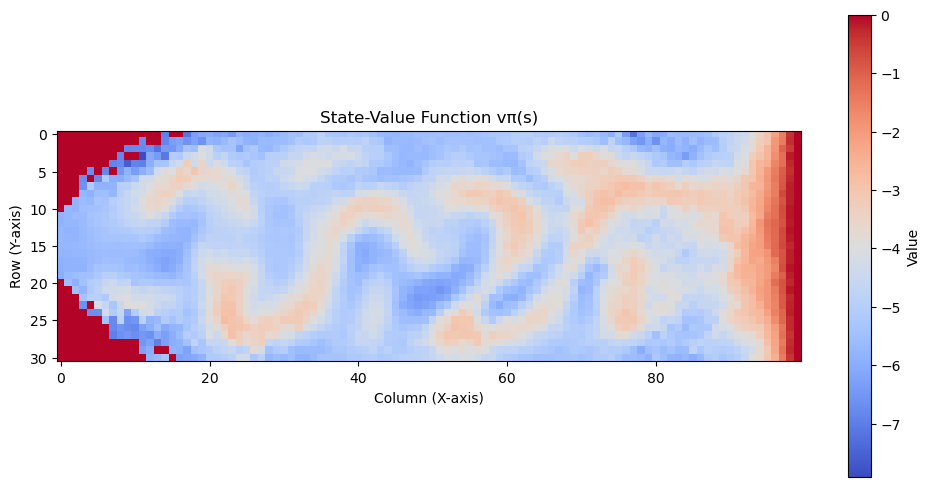

In [7]:
# Convert V_pi to a grid representation
grid_height = 31
grid_width = 100
V_grid = np.zeros((grid_height, grid_width))

for state, value in V_pi.items():
    row, col = state
    V_grid[row, col] = value

# Plot the state-value function vπ(s)
plt.figure(figsize=(12, 6))
plt.imshow(V_grid, cmap='coolwarm', origin='upper')
plt.colorbar(label="Value")
plt.title("State-Value Function vπ(s)")
plt.xlabel("Column (X-axis)")
plt.ylabel("Row (Y-axis)")
plt.show()

In [8]:
# Monte Carlo Policy Improvement: Extract the greedy policy
def mc_policy_improvement(Q):
    policy = {}

    for state in Q:
        # Choose the action with the highest value
        policy[state] = max(Q[state], key=Q[state].get)

    return policy

In [9]:
# Improve the policy
pi_prime = mc_policy_improvement(Q_pi)

In [10]:
# Compare the new policy with the old one
def is_policy_optimal(Q, pi_prime):
    for state in Q:
        best_action = max(Q[state], key=Q[state].get)
        if pi_prime[state] != best_action:
            return False  # Policy can still be improved
    return True

In [11]:
# Check if the policy is optimal
optimal = is_policy_optimal(Q_pi, pi_prime)
print(f"Is the improved policy optimal? {'Yes' if optimal else 'No'}")

Is the improved policy optimal? Yes


In [12]:
# Count how many states had a policy change
policy_changes = sum(1 for s in pi_prime if pi_prime[s] != max(Q_pi[s], key=Q_pi[s].get))
print(f"Number of states where policy changed: {policy_changes}")

Number of states where policy changed: 0


## 5 commenting on results

**MC Evaluation Result**
* The value function heatmap remained consistent with the terrain structure, indicating that the robot's movement was well-aligned with terrain difficulty.

**MC Policy Improvement Results**
* After applying MC policy improvement, the number of policy changes was 0, meaning the original policy was already optimal (or near-optimal).
* This suggests that the SpaceY trajectories were generated using a well-optimized policy, meaning further policy improvements were unnecessary.

**Are All Trajectories Equally Useful for MC Evaluation and Improvement?**
No, not all trajectories are equally useful. Here’s why:
1. Some Trajectories Provide More Information
    * Good trajectories (those that follow high-reward paths) are valuable because they reinforce optimal policy decisions.
    * Exploratory or suboptimal trajectories may not contribute much if they rarely visit useful states.
2. Coverage of the State Space
    * If some states are rarely visited in the given trajectories, their value estimates will be unreliable.
    * Monte Carlo methods rely on many visits to different states to get accurate estimates.
    * If trajectories don’t cover all important states, some parts of the value function may be inaccurate.
3. Finite Trajectories
    * Since the robot’s battery limits the number of steps, all trajectories are finite.
    * Some states might not be evaluated with long-term returns because episodes end early.

## 6 MC Control

In [13]:
# Environment dimensions
STATE_SPACE = (31, 100)  # 31 rows, 100 columns
ACTION_SPACE = 5  # 5 possible actions

In [14]:
def mc_control(env, gamma=0.9, episodes=20000, epsilon=0.2, alpha=0.1, threshold=0.1):
    """
    Monte Carlo Control with Epsilon-Greedy, First-Visit MC, and Convergence Monitoring.

    Args:
        env: Gym environment instance.
        gamma: Discount factor.
        episodes: Number of episodes for evaluation.
        epsilon: Exploration rate.
        alpha: Learning rate for Q-value updates.
        threshold: Convergence threshold for policy stability.

    Returns:
        Optimal policy and action-value function.
    """
    set_seed(42)

    env.action_space.seed(42)  # Ensure Gym uses the same random seed
    env.reset(seed=42)  # Reset environment with seed

    Q = defaultdict(float)  # Q-values stored as Q[(state, action)]
    policy = defaultdict(lambda: np.random.choice(env.action_space.n))  # Initialize with random policy
    last_policy = {}
    total_rewards = []
    average_rewards = []

    for episode in range(1, episodes + 1):
        # Reset environment and get initial state
        observation, _ = env.reset()
        state = tuple(observation['agent']['pos']) if isinstance(observation, dict) else tuple(observation)

        episode_data = []
        done = False
        total_reward = 0

        # Generate an episode by interacting with the environment
        while not done:
            # Epsilon-greedy action selection
            action = policy[state] if np.random.rand() > epsilon else np.random.choice(env.action_space.n)

            # Step through the environment
            next_obs, reward, done, _, _ = env.step(action)
            next_state = tuple(next_obs['agent']['pos']) if isinstance(next_obs, dict) else tuple(next_obs)

            # Store transition
            episode_data.append((state, action, reward))
            state = next_state
            total_reward += reward

        # First-Visit MC Evaluation: Compute Returns
        G = 0
        visited = set()

        for state, action, reward in reversed(episode_data):
            G = reward + gamma * G

            # First-visit check
            if (state, action) not in visited:
                Q[(state, action)] += alpha * (G - Q[(state, action)])
                visited.add((state, action))

        # Policy Improvement Step (Epsilon-Greedy)
        current_policy = {}
        for state, _, _ in episode_data:
            actions = [Q.get((state, a), 0) for a in range(env.action_space.n)]
            best_action = np.argmax(actions)
            current_policy[state] = best_action
            policy[state] = best_action

        total_rewards.append(total_reward)

        # Convergence Check Every 100 Episodes
        if episode % 100 == 0:
            policy_changes = sum(1 for s in current_policy if current_policy[s] != last_policy.get(s, None))
            avg_reward = np.mean(total_rewards[-100:])
            average_rewards.append(avg_reward)
            print(f"Episode {episode}: Epsilon = {epsilon:.4f}, Policy Changes = {policy_changes}, Avg Reward = {avg_reward:.2f}")

            # Stop early if policy stabilizes
            if policy_changes / max(1, len(current_policy)) < threshold:
                print(f"\n Converged after {episode} episodes with {policy_changes} changes!")
                break

        last_policy = current_policy
        epsilon = max(0.01, 0.2 * (0.999 ** episode))  # Slower epsilon decay

    print(f"\n Final Epsilon: {epsilon}")
    print(f"Average Reward over last 500 episodes: {np.mean(total_rewards[500:]):.2f}")
    print(f"Parameters: gamma={gamma}, episodes={episodes}, epsilon={epsilon}, alpha={alpha}, threshold={threshold}")

    return policy, Q, average_rewards

In [15]:
set_seed(42)

env = MountainEnv()

# Run Monte Carlo Control
policy_env1, Q_env1, avg_rewards_env1 = mc_control(env, episodes=20000, threshold=0.1)

Episode 100: Epsilon = 0.1811, Policy Changes = 159, Avg Reward = -90.24
Episode 200: Epsilon = 0.1639, Policy Changes = 143, Avg Reward = -86.02
Episode 300: Epsilon = 0.1483, Policy Changes = 122, Avg Reward = -85.31
Episode 400: Epsilon = 0.1342, Policy Changes = 142, Avg Reward = -85.69
Episode 500: Epsilon = 0.1214, Policy Changes = 118, Avg Reward = -76.63
Episode 600: Epsilon = 0.1098, Policy Changes = 110, Avg Reward = -70.60
Episode 700: Epsilon = 0.0994, Policy Changes = 67, Avg Reward = -53.80
Episode 800: Epsilon = 0.0899, Policy Changes = 66, Avg Reward = -45.17
Episode 900: Epsilon = 0.0814, Policy Changes = 41, Avg Reward = -40.40
Episode 1000: Epsilon = 0.0736, Policy Changes = 43, Avg Reward = -37.65
Episode 1100: Epsilon = 0.0666, Policy Changes = 27, Avg Reward = -35.94
Episode 1200: Epsilon = 0.0603, Policy Changes = 41, Avg Reward = -34.50
Episode 1300: Epsilon = 0.0545, Policy Changes = 28, Avg Reward = -33.50
Episode 1400: Epsilon = 0.0493, Policy Changes = 32, A

In [17]:
# Compare two policies to check how many states changed
def compare_policies(old_policy, new_policy):
    """
    Compare old and new policies to count how many states changed their action.
    """
    changes = np.sum(old_policy != new_policy)  # NumPy comparison
    return changes

# Compare the updated policy with the previous one
policy_changes = compare_policies(policy_env1, np.random.randint(ACTION_SPACE, size=STATE_SPACE))  # Random baseline for now
print(f"Number of states where policy changed after MC Control: {policy_changes}")

Number of states where policy changed after MC Control: 3100


In [18]:
env2 = gym.make('mountain/GridWorld-v2')
# Run Monte Carlo Control (env2)
policy_env2, Q_env2, avg_rewards_env2 = mc_control(env2, episodes=20000, threshold=0.1)

c:\Users\sande\anaconda3\envs\gymenv\Lib\site-packages\gymnasium\utils\passive_env_checker.py:134: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be int32, actual type: int64
  logger.warn(
c:\Users\sande\anaconda3\envs\gymenv\Lib\site-packages\gymnasium\utils\passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\sande\anaconda3\envs\gymenv\Lib\site-packages\gymnasium\utils\passive_env_checker.py:134: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be int32, actual type: int64
  logger.warn(
c:\Users\sande\anaconda3\envs\gymenv\Lib\site-packages\gymnasium\utils\passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


Episode 100: Epsilon = 0.1811, Policy Changes = 104, Avg Reward = -165.23
Episode 200: Epsilon = 0.1639, Policy Changes = 26, Avg Reward = -171.37
Episode 300: Epsilon = 0.1483, Policy Changes = 20, Avg Reward = -171.10
Episode 400: Epsilon = 0.1342, Policy Changes = 23, Avg Reward = -170.75
Episode 500: Epsilon = 0.1214, Policy Changes = 10, Avg Reward = -170.84
Episode 600: Epsilon = 0.1098, Policy Changes = 24, Avg Reward = -173.20
Episode 700: Epsilon = 0.0994, Policy Changes = 4, Avg Reward = -171.08
Episode 800: Epsilon = 0.0899, Policy Changes = 20, Avg Reward = -167.91
Episode 900: Epsilon = 0.0814, Policy Changes = 18, Avg Reward = -170.70
Episode 1000: Epsilon = 0.0736, Policy Changes = 46, Avg Reward = -165.89
Episode 1100: Epsilon = 0.0666, Policy Changes = 19, Avg Reward = -169.76
Episode 1200: Epsilon = 0.0603, Policy Changes = 37, Avg Reward = -168.81
Episode 1300: Epsilon = 0.0545, Policy Changes = 20, Avg Reward = -169.75
Episode 1400: Epsilon = 0.0493, Policy Changes 

In [19]:
def visualize_optimal_path(env, policy, title="Optimal Path Over Mountain Environment"):
    """
    Simulates the trained policy and overlays the path on the terrain map.
    """
    state, _ = env.reset(seed=42)  # Reset environment for consistent visualization
    state = tuple(state['agent']['pos']) if isinstance(state, dict) else tuple(state)

    path = [state]  # Track path taken
    done = False

    while not done:
        action = policy[state]  # Follow trained policy
        next_obs, _, done, _, _ = env.step(action)
        state = tuple(next_obs['agent']['pos']) if isinstance(next_obs, dict) else tuple(next_obs)
        path.append(state)

    # Extract X, Y coordinates for path
    path_x = [p[1] for p in path]  # Columns
    path_y = [p[0] for p in path]  # Rows

    # FIX: Ensure each environment uses its own map
    plt.figure(figsize=(12, 6))
    plt.imshow(env.unwrapped.MAP, cmap='terrain', origin='upper')
    plt.colorbar(label='Elevation')
    plt.plot(path_x, path_y, marker='o', color='red', markersize=3, linestyle='-', linewidth=2, label="Optimal Path")
    plt.title(title)
    plt.legend()
    plt.show()

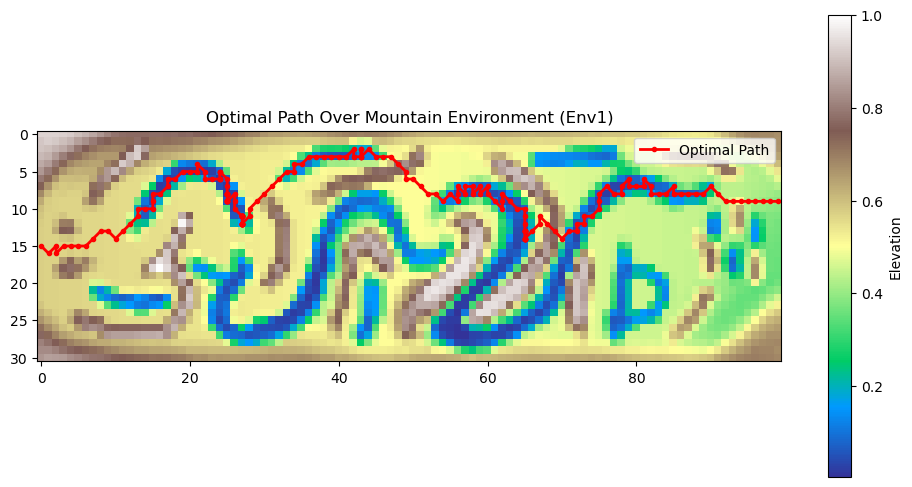

In [20]:
visualize_optimal_path(env, policy_env1, title="Optimal Path Over Mountain Environment (Env1)")

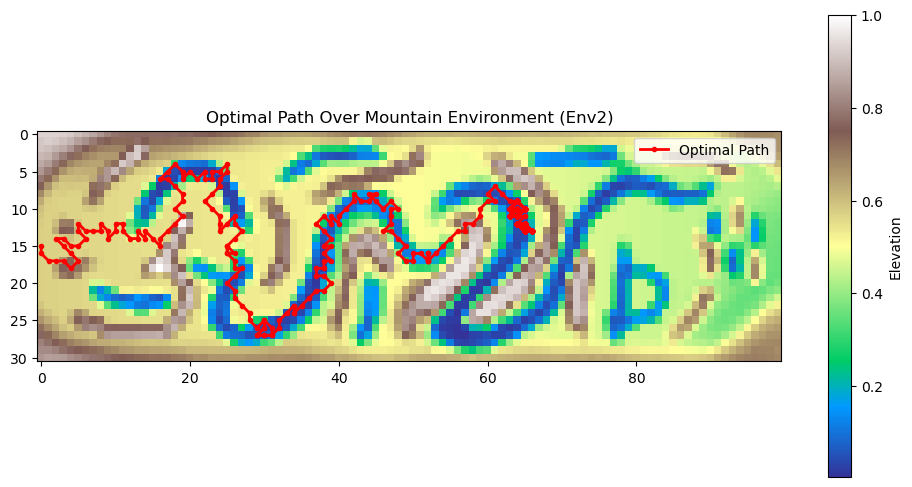

In [21]:
visualize_optimal_path(env2, policy_env2, title="Optimal Path Over Mountain Environment (Env2)")